In [1]:
from large_gcs.algorithms.gcs_astar_reachability import GcsAstarReachability
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.graph.cost_constraint_factory import (
    shortcut_edge_cost_factory,
)
from large_gcs.algorithms.search_algorithm import SearchNode
from large_gcs.graph.graph import ShortestPathSolution
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
)
from large_gcs.domination_checkers.sampling_domination_checker import SetSamples
from large_gcs.contact.contact_set import ContactSet
from large_gcs.graph.contact_cost_constraint_factory import contact_shortcut_edge_l1_norm_cost_factory_over_obj_weighted
from large_gcs.algorithms.search_algorithm import AlgMetrics
from large_gcs.domination_checkers.reaches_cheaper_sampling import ReachesCheaperSampling
from large_gcs.domination_checkers.reaches_cheaper_last_pos_sampling import ReachesCheaperLastPosSampling
from large_gcs.domination_checkers.reaches_cheaper_containment import ReachesCheaperContainment
import numpy as np
from IPython.display import HTML

import logging

logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.DEBUG)
logging.getLogger(__name__).setLevel(logging.DEBUG)
logger = logging.getLogger(__name__)

/home/shaoyuan/Documents/Software/pypolycontain/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/home/shaoyuan/Documents/Software/pypolycontain/pypolycontain/containment.py:16: UserWarning: You don't have CDD package installed. Unable to run cone ray generation.
  warnings.warn("You don't have CDD package installed. Unable to run cone ray generation.")


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 30393.51it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 14388.69it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 201.51it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (151)
100%|██████████| 151/151 [00:00<00:00, 3664.89it/s]


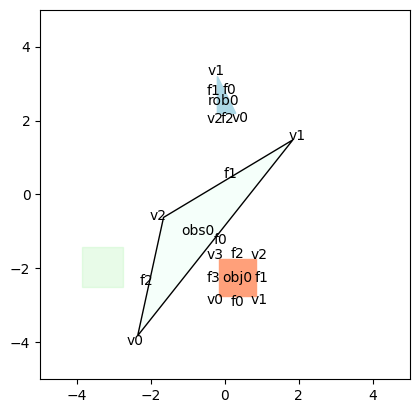

In [2]:
graph_file = ContactGraphGeneratorParams.inc_graph_file_path_from_name("cg_maze_b1")
cg = IncrementalContactGraph.load_from_file(
    graph_file,
    should_incl_simul_mode_switches=False,
    should_add_const_edge_cost=True,
    should_add_gcs=True,
    should_use_l1_norm_vertex_cost=True,
)
cg.plot()

In [3]:
vertex_path = ['source', "('NC|obs0_f0-obj0_v3', 'NC|obs0_f1-rob0_v0', 'NC|obj0_f2-rob0_f2')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_v1-rob0_f2', 'NC|obj0_f2-rob0_f2')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f2-rob0_f2')"]

cg.set_target("target")
for v in vertex_path[:-1]:
    cg.generate_neighbors(v)

In [4]:
n = SearchNode.from_vertex_path(vertex_path)
# set_samples = SetSamples.from_vertex(n.vertex_name, cg.vertices[n.vertex_name], 1)
# # cg.plot_samples_in_set(n.vertex_name, set_samples.samples)

# for sample in set_samples.samples:
#     cg.plot_samples_in_set(n.vertex_name, np.array([sample]))

## AH Containment

In [6]:
domination_checker = ReachesCheaperContainment(cg)
domination_checker.set_alg_metrics(AlgMetrics())
A, b, C, d = domination_checker.get_path_A_b_C_d(n)
H = np.vstack([A, C, -C])
h = np.hstack([b, d, -d])
T_H = domination_checker.get_H_transformation(n, H.shape[0])
H.shape, T_H.shape

DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:Total number of decision variables 47, sum of v_dims 34
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:processing vertex constraint vertices[0]
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:processing vertex constraint vertices[1]
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:processing vertex constraint vertices[2]
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:processing vertex constraint vertices[3]
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:processing edge constraint edge[0]
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:constraint <pydrake.solvers.LinearEqualityConstraint object at 0x7c9facf77970>
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:Adding linear equality constraint
DEBUG:large_gcs.domination_checkers.ah_containment_domination_checker:pr

((147, 47), (11, 47))

In [7]:
from large_gcs.geometry.geometry_utils import create_selection_matrix

vertices = [cg.vertices[name].gcs_vertex for name in n.vertex_path]

v_dims = [v.ambient_dimension() for v in vertices]
current_index = 0

x = []
for i, dim in enumerate(v_dims):
    x.append(list(range(current_index, current_index + dim)))
    current_index += dim

N = 47
con_var_indices = x[-1] + [N - 1]
print(con_var_indices)
S = create_selection_matrix(con_var_indices, N)
S.shape

[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 46]


(11, 47)

In [10]:
terminal_set:ContactSet = cg.vertices[n.vertex_name].convex_set
con_var_indices = terminal_set.vars.last_pos_from_all(x[-1])
con_var_indices

array([25, 27, 29, 31])

In [8]:
assert np.allclose(S, T_H)

In [9]:
S

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
    

## Sampling

In [ ]:



domination_checker = ReachesCheaperLastPosSampling(cg, 1, False)
domination_checker.set_alg_metrics(AlgMetrics())
domination_checker.is_dominated(n, [n])

## Constraining the last position knot point

In [ ]:
# Extract last position knot point from sample

contact_set: ContactSet = cg.vertices[n.vertex_name].convex_set
contact_set.vars.pos

In [ ]:
last_pos = contact_set.vars.pos[:, :, -1]
last_pos

In [ ]:
pos_sample = contact_set.vars.pos_from_all(set_samples.samples[0])
pos_sample

In [ ]:
last_pos_sample = pos_sample[:, :, -1]
last_pos_sample

In [ ]:
from pydrake.all import DecomposeAffineExpressions


exprs = last_pos.flatten() - last_pos_sample.flatten()
A, b = DecomposeAffineExpressions(exprs, contact_set.vars.all)

In [ ]:
A

In [ ]:
b

In [ ]:
from large_gcs.graph.contact_cost_constraint_factory import vertex_constraint_last_pos_equality


constraint = vertex_constraint_last_pos_equality(contact_set.vars, set_samples.samples[0])

In [ ]:
from IPython.display import display, Math


display(Math(constraint.ToLatex(contact_set.vars.all)))

In [ ]:
from large_gcs.graph.contact_cost_constraint_factory import vertex_constraint_last_pos_eps_equality


constraint = vertex_constraint_last_pos_eps_equality(contact_set.vars, set_samples.samples[0], 1e-3)
display(Math(constraint.ToLatex(contact_set.vars.all)))